In [1]:
from spacepy import pycdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
from scipy import stats
from mpl_toolkits.mplot3d import axes3d
import matplotlib
import matplotlib.colors as colors
from collections import Counter
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import math
from lmfit.models import GaussianModel
from sklearn import mixture
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import cdflib
from matplotlib import ticker, cm
import pandas as pd
from minisom import MiniSom

# 2005-08-28 Outlier Event

In [2]:
cdf = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_FGM_SPIN__20050828_161837_20050828_180027_V140305')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf, start=0):
    print(i, item, cdf[i])

0 time_tags__C4_CP_FGM_SPIN CDF_EPOCH [1473]
1 half_interval__C4_CP_FGM_SPIN CDF_FLOAT [1473]
2 B_vec_xyz_gse__C4_CP_FGM_SPIN CDF_FLOAT [1473, 3]
3 B_mag__C4_CP_FGM_SPIN CDF_FLOAT [1473]
4 sc_pos_xyz_gse__C4_CP_FGM_SPIN CDF_FLOAT [1473, 3]
5 range__C4_CP_FGM_SPIN CDF_INT4 [1473]
6 tm__C4_CP_FGM_SPIN CDF_INT4 [1473]
7 B_vec_xyz_gse__C4_CP_FGM_SPIN_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
8 B_vec_xyz_gse__C4_CP_FGM_SPIN_LABEL_1 CDF_CHAR*2 [3] NRV
9 sc_pos_xyz_gse__C4_CP_FGM_SPIN_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
10 sc_pos_xyz_gse__C4_CP_FGM_SPIN_LABEL_1 CDF_CHAR*1 [3] NRV


In [3]:
epoch = cdf[0][...]
B_vec = cdf[2][...] #nT
B_mag = cdf[3][...] #nT
position = cdf[4][...] #km

In [4]:
df = pd.DataFrame({'Timestamp':epoch, 'B_mag':B_mag})

In [5]:
cdf1 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_CIS-CODIF_HS_H1_MOMENTS__20050828_161837_20050828_180027_V081210')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf1, start=0):
    print(i, item, cdf1[i])

0 time_tags__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_EPOCH [736]
1 duration__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736]
2 density__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736]
3 velocity__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736, 3]
4 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736, 3, 3]
5 T__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736]
6 T_par__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736]
7 T_perp__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [736]
8 velocity__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
9 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
10 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_2 CDF_CHAR*1 [3] NRV
11 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_LABEL_1 CDF_CHAR*1 [3] NRV
12 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_LABEL_2 CDF_CHAR*1 [3] NRV


In [6]:
epoch1 = cdf1[0][...]
density1 = cdf1[2][...] #cm-3
vel1 = cdf1[3][...] #km/s
pressure1 = cdf1[4][...] #nPa
T1 = cdf1[5][...] #MK
T_par1 = cdf1[6][...] #MK
T_perp1 = cdf1[7][...] #MK
k_b = 1.38e-23 #m^2 kg s^-2 K^-1
mu_0 = 1.26e-6 #m kg s^-2 A^-2
vel_tot1 = np.sqrt((vel1[:,0]**2)+(vel1[:,1]**2)+vel1[:,2]**2)

In [7]:
df1 = pd.DataFrame({'Timestamp':epoch1, 'density':density1, 'T':T1})

In [8]:
# merge CIS and FGM data into one dataframe based on timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df_12 = pd.merge_asof(df1, df, on='Timestamp')
# calculate proton plasma beta
plasma_beta = (df_12['density']*(100**3)*k_b*df_12['T']*(10**6))/(((df_12['B_mag']*(10**-9))**2)/(2*mu_0))
df_12['plasma_beta'] = plasma_beta

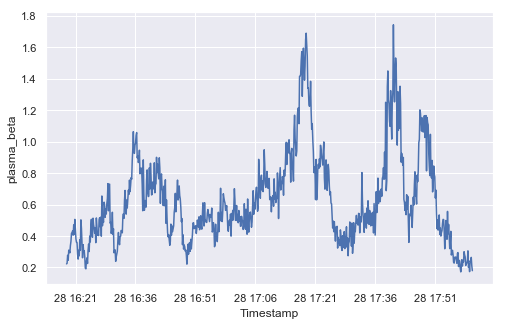

In [9]:
# plasma beta
plt.figure(figsize=(8,5))
sns.lineplot(x="Timestamp", y="plasma_beta", data=df_12)

In [10]:
for i in range(len(plasma_beta)):
    print(i,df_12['Timestamp'].iloc[i],df_12['plasma_beta'].iloc[i])

0 2005-08-28 16:18:44.683000 0.22288052382995296
1 2005-08-28 16:18:52.961000 0.22699195198470493
2 2005-08-28 16:19:01.257000 0.2776450283109087
3 2005-08-28 16:19:09.554000 0.2460043933566869
4 2005-08-28 16:19:17.848000 0.3101306716837336
5 2005-08-28 16:19:26.144000 0.3045098422712584
6 2005-08-28 16:19:34.422000 0.29320295431454585
7 2005-08-28 16:19:42.718000 0.33938661655529123
8 2005-08-28 16:19:51.015000 0.3660212939637254
9 2005-08-28 16:19:59.308000 0.41775867696186525
10 2005-08-28 16:20:07.588000 0.4184687728880892
11 2005-08-28 16:20:15.883000 0.4322855848290213
12 2005-08-28 16:20:24.179000 0.4054329217779196
13 2005-08-28 16:20:32.475000 0.47083007932475057
14 2005-08-28 16:20:40.769000 0.40995837322337036
15 2005-08-28 16:20:49.049000 0.5055933962873385
16 2005-08-28 16:20:57.343000 0.44305662842337223
17 2005-08-28 16:21:05.640000 0.3816370650941799
18 2005-08-28 16:21:13.936000 0.36037031231167765
19 2005-08-28 16:21:22.229000 0.3586952114369611
20 2005-08-28 16:21:3

553 2005-08-28 17:35:10.176000 0.5457625990300783
554 2005-08-28 17:35:18.469000 0.468064694024359
555 2005-08-28 17:35:26.766000 0.5509091677987262
556 2005-08-28 17:35:35.060000 0.41964801615716885
557 2005-08-28 17:35:43.341000 0.6060870660694049
558 2005-08-28 17:35:51.637000 0.5037135071066586
559 2005-08-28 17:35:59.930000 0.4058051386565304
560 2005-08-28 17:36:08.227000 0.5435670421459978
561 2005-08-28 17:36:16.507000 0.6821372557864253
562 2005-08-28 17:36:24.801000 0.5488289230152711
563 2005-08-28 17:36:33.097000 0.5976102850373884
564 2005-08-28 17:36:41.391000 0.7679755233864557
565 2005-08-28 17:36:49.687000 0.6070515966851876
566 2005-08-28 17:36:57.968000 0.6528173656140629
567 2005-08-28 17:37:06.262000 0.6857001043911053
568 2005-08-28 17:37:14.558000 0.618269155669788
569 2005-08-28 17:37:22.852000 0.6699860064136984
570 2005-08-28 17:37:31.148000 0.6990613800385934
571 2005-08-28 17:37:39.426000 0.6525857874332205
572 2005-08-28 17:37:47.722000 0.7662237162463384
5

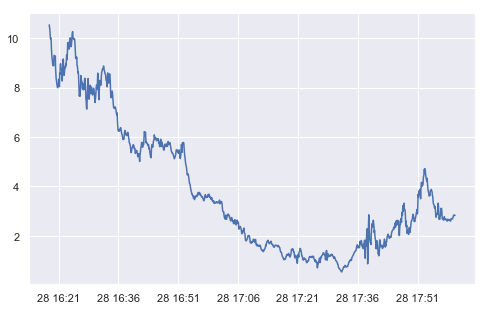

In [11]:
# plot IMF z-component against time
plt.figure(figsize=(8,5))
plt.plot(epoch,B_vec[:,2])

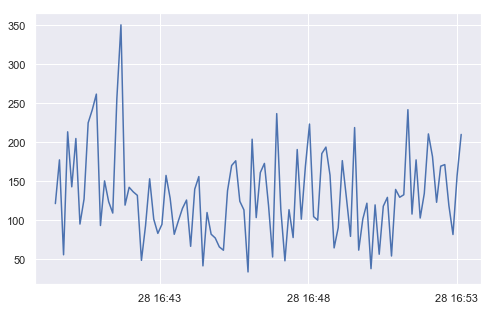

In [12]:
# plasma flow velocity from CIS
plt.figure(figsize=(8,5))
plt.plot(epoch1[150:250],vel_tot1[150:250])

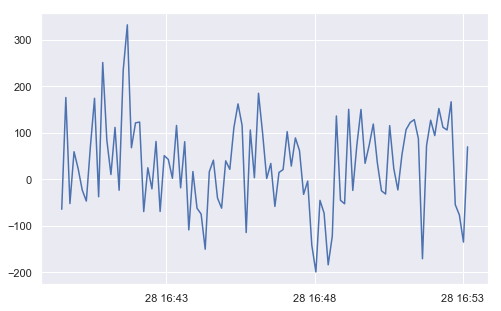

In [19]:
# plasma flow v_x from CIS
plt.figure(figsize=(8,5))
plt.plot(epoch1[150:250],vel1[150:250,0])

In [13]:
cdf2 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_PEA_MOMENTS__20050828_161837_20050828_180027_V190319')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf2, start=0):
    print(i, item, cdf2[i])

0 time_tags__C4_CP_PEA_MOMENTS CDF_EPOCH [435]
1 time_tags_DeltaLower__C4_CP_PEA_MOMENTS CDF_FLOAT [435]
2 time_tags_DeltaUpper__C4_CP_PEA_MOMENTS CDF_FLOAT [435]
3 Mode_Sensor__C4_CP_PEA_MOMENTS CDF_INT4 [435]
4 Mode_SweepMode_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
5 Mode_Preset_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
6 Mode_EnergyLevelRange_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435, 2]
7 Mode_EnergyMaxMin_HEEA__C4_CP_PEA_MOMENTS CDF_FLOAT [435, 2]
8 Mode_MCPlevel_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
9 Mode_DataOrigin_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
10 Mode_SweepMode_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
11 Mode_Preset_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
12 Mode_EnergyLevelRange_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435, 2]
13 Mode_EnergyMaxMin_LEEA__C4_CP_PEA_MOMENTS CDF_FLOAT [435, 2]
14 Mode_MCPlevel_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
15 Mode_DataOrigin_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [435]
16 Mode_TopRegionSensor__C4_CP_PEA_MOMENTS CDF_INT4 [435]
17 Mode_OverlapRegionSens

In [14]:
epoch2 = cdf2[0][...]
density2 = cdf2[19][...] #cm-3
vel2 = cdf2[20][...] #km/s
pressure2 = cdf2[23][...] #nPa
heat_flux2 = cdf2[24][...] #microW/m^2
T_par2 = cdf2[25][...] #MK
T_perp2 = cdf2[26][...] #MK

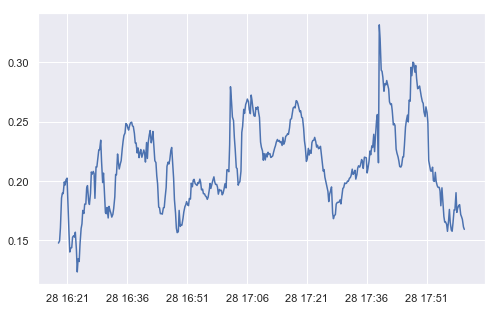

In [15]:
# electron density
plt.figure(figsize=(8,5))
plt.plot(epoch2,density2)

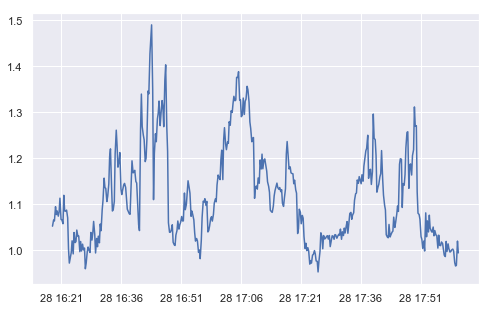

In [16]:
# electron temperature anisotropy
plt.figure(figsize=(8,5))
plt.plot(epoch2,T_par2/T_perp2)

In [36]:
for i in range(len(epoch2)):
    print(i,epoch2[i],T_par2[i]/T_perp2[i])

0 2005-08-28 16:18:48.815000 1.051689
1 2005-08-28 16:19:05.393000 1.065052
2 2005-08-28 16:19:17.832000 1.0631186
3 2005-08-28 16:19:34.421000 1.0940589
4 2005-08-28 16:19:46.853000 1.0769303
5 2005-08-28 16:19:59.293000 1.0847579
6 2005-08-28 16:20:15.880000 1.0734861
7 2005-08-28 16:20:28.314000 1.0826083
8 2005-08-28 16:20:40.751000 1.1125064
9 2005-08-28 16:20:57.311000 1.0663301
10 2005-08-28 16:21:09.774000 1.0654259
11 2005-08-28 16:21:26.358000 1.0570371
12 2005-08-28 16:21:38.783000 1.1187775
13 2005-08-28 16:21:51.233000 1.0848756
14 2005-08-28 16:22:07.818000 1.0841924
15 2005-08-28 16:22:20.250000 1.0866296
16 2005-08-28 16:22:36.840000 1.0699031
17 2005-08-28 16:22:49.279000 1.0022396
18 2005-08-28 16:23:01.716000 0.97151375
19 2005-08-28 16:23:18.304000 0.9847911
20 2005-08-28 16:23:30.739000 0.99455875
21 2005-08-28 16:23:43.177000 1.0199001
22 2005-08-28 16:23:59.737000 0.99147695
23 2005-08-28 16:24:12.198000 1.0379478
24 2005-08-28 16:24:28.783000 1.0160762
25 2005-0

# 2003-10-13 Outlier Event

In [19]:
cdf3 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_FGM_SPIN__20031013_105830_20031013_123207_V140305')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf3, start=0):
    print(i, item, cdf3[i])

0 time_tags__C4_CP_FGM_SPIN CDF_EPOCH [1398]
1 half_interval__C4_CP_FGM_SPIN CDF_FLOAT [1398]
2 B_vec_xyz_gse__C4_CP_FGM_SPIN CDF_FLOAT [1398, 3]
3 B_mag__C4_CP_FGM_SPIN CDF_FLOAT [1398]
4 sc_pos_xyz_gse__C4_CP_FGM_SPIN CDF_FLOAT [1398, 3]
5 range__C4_CP_FGM_SPIN CDF_INT4 [1398]
6 tm__C4_CP_FGM_SPIN CDF_INT4 [1398]
7 B_vec_xyz_gse__C4_CP_FGM_SPIN_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
8 B_vec_xyz_gse__C4_CP_FGM_SPIN_LABEL_1 CDF_CHAR*2 [3] NRV
9 sc_pos_xyz_gse__C4_CP_FGM_SPIN_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
10 sc_pos_xyz_gse__C4_CP_FGM_SPIN_LABEL_1 CDF_CHAR*1 [3] NRV


In [20]:
epoch3 = cdf3[0][...]
B_vec3 = cdf3[2][...] #nT
B_mag3 = cdf3[3][...] #nT
position3 = cdf3[4][...] #km

In [21]:
df3 = pd.DataFrame({'Timestamp':epoch3, 'B_mag':B_mag3})

In [22]:
cdf4 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_CIS-CODIF_HS_H1_MOMENTS__20031013_105830_20031013_123207_V080213')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf4, start=0):
    print(i, item, cdf4[i])

0 time_tags__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_EPOCH [700]
1 duration__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700]
2 density__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700]
3 velocity__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700, 3]
4 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700, 3, 3]
5 T__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700]
6 T_par__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700]
7 T_perp__C4_CP_CIS-CODIF_HS_H1_MOMENTS CDF_FLOAT [700]
8 velocity__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
9 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_1 CDF_CHAR*1 [3] NRV
10 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_REPRESENTATION_2 CDF_CHAR*1 [3] NRV
11 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_LABEL_1 CDF_CHAR*1 [3] NRV
12 pressure__C4_CP_CIS-CODIF_HS_H1_MOMENTS_LABEL_2 CDF_CHAR*1 [3] NRV


In [23]:
epoch4 = cdf4[0][...]
density4 = cdf4[2][...] #cm-3
vel4 = cdf4[3][...] #km/s
pressure4 = cdf4[4][...] #nPa
T4 = cdf4[5][...] #MK
T_par4 = cdf4[6][...] #MK
T_perp4 = cdf4[7][...] #MK
k_b = 1.38e-23 #m^2 kg s^-2 K^-1
mu_0 = 1.26e-6 #m kg s^-2 A^-2
vel_tot4 = np.sqrt((vel4[:,0]**2)+(vel4[:,1]**2)+vel4[:,2]**2)

In [24]:
df4 = pd.DataFrame({'Timestamp':epoch4, 'density':density4, 'T':T4})

In [25]:
# merge CIS and FGM data into one dataframe based on timestamp
df3['Timestamp'] = pd.to_datetime(df3['Timestamp'])
df4['Timestamp'] = pd.to_datetime(df4['Timestamp'])
df_34 = pd.merge_asof(df4, df3, on='Timestamp')
# calculate proton plasma beta
plasma_beta34 = (df_34['density']*(100**3)*k_b*df_34['T']*(10**6))/(((df_34['B_mag']*(10**-9))**2)/(2*mu_0))
df_34['plasma_beta'] = plasma_beta34

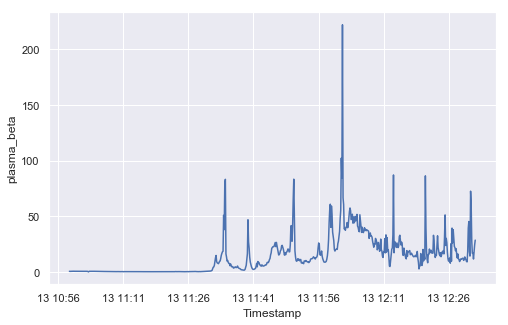

In [26]:
# plasma beta
plt.figure(figsize=(8,5))
sns.lineplot(x="Timestamp", y="plasma_beta", data=df_34)

In [27]:
for i in range(len(plasma_beta34)):
    print(i,df_34['Timestamp'].iloc[i],df_34['plasma_beta'].iloc[i])

0 2003-10-13 10:58:35.160000 0.6193339818658474
1 2003-10-13 10:58:43.179000 0.5385875200690532
2 2003-10-13 10:58:51.198000 0.5677178320520322
3 2003-10-13 10:58:59.199000 0.5919280792113144
4 2003-10-13 10:59:07.218000 0.6086958070004934
5 2003-10-13 10:59:15.235000 0.6407876583661095
6 2003-10-13 10:59:23.254000 0.6338320700375835
7 2003-10-13 10:59:31.272000 0.6515824540272751
8 2003-10-13 10:59:39.290000 0.6084896290048329
9 2003-10-13 10:59:47.309000 0.6066269966752469
10 2003-10-13 10:59:55.326000 0.6077177946244655
11 2003-10-13 11:00:03.344000 0.6021223210784247
12 2003-10-13 11:00:11.361000 0.529907334960391
13 2003-10-13 11:00:19.365000 0.5440703780312769
14 2003-10-13 11:00:27.382000 0.532358887625522
15 2003-10-13 11:00:35.401000 0.5333305791613008
16 2003-10-13 11:00:43.418000 0.5161158632765361
17 2003-10-13 11:00:51.437000 0.5157095267828605
18 2003-10-13 11:00:59.456000 0.520417836439888
19 2003-10-13 11:01:07.473000 0.5044240763693292
20 2003-10-13 11:01:15.491000 0.5

533 2003-10-13 12:09:55.905000 23.496296258967988
534 2003-10-13 12:10:03.923000 18.530189160188087
535 2003-10-13 12:10:11.940000 19.673784846799194
536 2003-10-13 12:10:19.944000 29.517291683805016
537 2003-10-13 12:10:27.962000 20.106948523022044
538 2003-10-13 12:10:35.979000 18.636407279398323
539 2003-10-13 12:10:43.998000 14.186319208429731
540 2003-10-13 12:10:52.015000 13.025976510314267
541 2003-10-13 12:11:00.033000 18.27099939458051
542 2003-10-13 12:11:08.051000 18.05811743151362
543 2003-10-13 12:11:16.070000 29.964057113909398
544 2003-10-13 12:11:24.089000 17.136943153455896
545 2003-10-13 12:11:32.090000 33.27759048733051
546 2003-10-13 12:11:40.108000 17.868918331494246
547 2003-10-13 12:11:48.126000 30.838174361625775
548 2003-10-13 12:11:56.145000 19.52185083324865
549 2003-10-13 12:12:04.162000 20.02594990554152
550 2003-10-13 12:12:12.181000 13.632214571139066
551 2003-10-13 12:12:20.198000 5.273414544073263
552 2003-10-13 12:12:28.216000 4.881120335717677
553 200

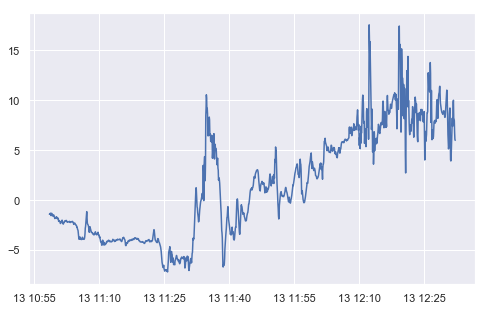

In [28]:
# plot IMF z-component against time
plt.figure(figsize=(8,5))
plt.plot(epoch3,B_vec3[:,2])

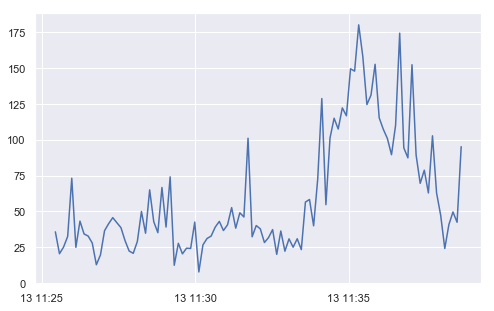

In [30]:
# plasma flow velocity from CIS
plt.figure(figsize=(8,5))
plt.plot(epoch4[200:300],vel_tot4[200:300])

In [31]:
cdf5 = pycdf.CDF('/Users/mayur/PhD/Cluster_data/ECLAT/C4_CP_PEA_MOMENTS__20031013_105830_20031013_123207_V140315')
#/disk/user1/mrb2/Cluster_data/... if on linux
for (i, item) in enumerate(cdf5, start=0):
    print(i, item, cdf5[i])

0 time_tags__C4_CP_PEA_MOMENTS CDF_EPOCH [379]
1 time_tags_DeltaLower__C4_CP_PEA_MOMENTS CDF_FLOAT [379]
2 time_tags_DeltaUpper__C4_CP_PEA_MOMENTS CDF_FLOAT [379]
3 Mode_Sensor__C4_CP_PEA_MOMENTS CDF_INT4 [379]
4 Mode_SweepMode_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
5 Mode_Preset_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
6 Mode_EnergyLevelRange_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379, 2]
7 Mode_EnergyMaxMin_HEEA__C4_CP_PEA_MOMENTS CDF_FLOAT [379, 2]
8 Mode_MCPlevel_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
9 Mode_DataOrigin_HEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
10 Mode_SweepMode_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
11 Mode_Preset_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
12 Mode_EnergyLevelRange_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379, 2]
13 Mode_EnergyMaxMin_LEEA__C4_CP_PEA_MOMENTS CDF_FLOAT [379, 2]
14 Mode_MCPlevel_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
15 Mode_DataOrigin_LEEA__C4_CP_PEA_MOMENTS CDF_INT4 [379]
16 Mode_TopRegionSensor__C4_CP_PEA_MOMENTS CDF_INT4 [379]
17 Mode_OverlapRegionSens

In [32]:
epoch5 = cdf5[0][...]
density5 = cdf5[19][...] #cm-3
vel5 = cdf5[20][...] #km/s
pressure5 = cdf5[23][...] #nPa
heat_flux5 = cdf5[24][...] #microW/m^2
T_par5 = cdf5[25][...] #MK
T_perp5 = cdf5[26][...] #MK

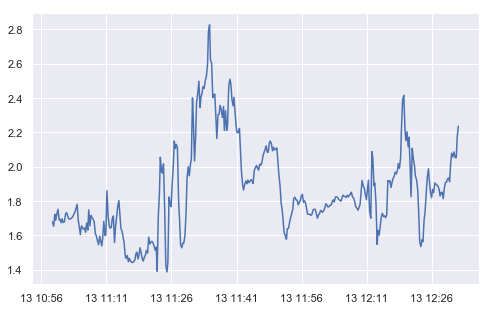

In [33]:
# electron density
plt.figure(figsize=(8,5))
plt.plot(epoch5,density5)

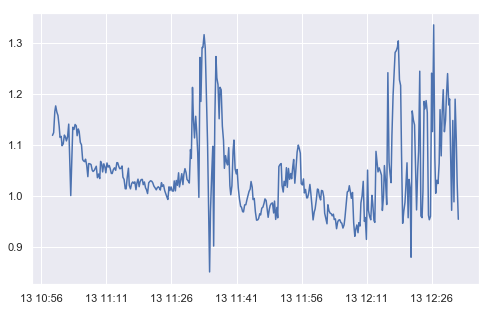

In [34]:
# electron temperature anisotropy
plt.figure(figsize=(8,5))
plt.plot(epoch5,T_par5/T_perp5)